In [24]:
import pathlib
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from glob import glob
import pandas as pd


import SessionTools.two_photon as st2p


%load_ext autoreload
%autoreload 2 

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
base_dir = pathlib.PurePath('/media/mplitt/SSD_storage/2P_scratch/EPG_jGCaMP7b_VK05/07_02_2024/')

In [9]:
flies = [f'fly{i}' for i in range(1,5)]
print(flies)


['fly1', 'fly2', 'fly3', 'fly4']


In [26]:

def calc_pva(y, pp):
    n_rois = y.shape[1]
    x_f,y_f = st2p.utilities.pol2cart(y[0,:,:],np.linspace(-np.pi,np.pi,num=n_rois)[:,np.newaxis])
    rho,phi = st2p.utilities.cart2pol(x_f.mean(axis=0), y_f.mean(axis=0))
    # print(rho.shape, phi.shape)

    heading = -1* pp.voltage_recording_aligned[' Heading'].to_numpy()

    _,offset = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),phi-heading))
    
    return phi, offset, heading

In [39]:
data = {'fly':[], 'closed_loop':[], 'drug': [],  'circvar':[], 'num':[]}

for fly in flies:
    workdir = base_dir / fly

    cl_sessions = glob(f'{workdir}/*closed_loop-*')
    dark_sessions = glob(f'{workdir}/*dark*')

    for i, cl_sess in enumerate(cl_sessions):
        
        if 'mianserin' in cl_sess:
            drug=True
        else:
            drug = False
            
        pkldir = pathlib.Path(cl_sess) / 'preprocess.pkl'
        pp = st2p.preprocessing.EBImagingSession.from_file(pkldir)
        y = pp.timeseries['rois_z']
        phi, offset, heading = calc_pva(y, pp)
        data['fly'].append(fly)
        data['closed_loop'].append(True)
        data['drug'].append(drug)
        data['num'].append(i)
        data['circvar'].append(sp.stats.circvar(offset))
        
        print(sp.stats.circvar(offset))
        
        
    for i, d_sess in enumerate(dark_sessions):
        pkldir = pathlib.Path(d_sess) / 'preprocess.pkl'
        pp = st2p.preprocessing.EBImagingSession.from_file(pkldir)
        y = pp.timeseries['rois_z']
        phi, offset, heading = calc_pva(y, pp)
        
        data['fly'].append(fly)
        data['closed_loop'].append(False)
        data['drug'].append(drug)
        data['num'].append(i)
        data['circvar'].append(sp.stats.circvar(offset))

data = pd.DataFrame.from_dict(data)

0.6395155581303984
0.4823356846331174
0.6088269142752388
0.5467595241963509
0.47727259746449724
0.7803528873792502
0.8011015395707523
0.6363518413220792
0.744341452340195


0    0.639516
1    0.482336
2    0.608827
5    0.546760
6    0.477273
Name: circvar, dtype: float64
0.5509420557399205
9     0.780353
10    0.801102
13    0.636352
14    0.744341
Name: circvar, dtype: float64
0.7405369301530691
3    0.813485
4    0.896520
7    0.877557
8    0.811006
Name: circvar, dtype: float64
0.8496419241742976
11    0.792025
12    0.928825
15    0.919198
16    0.776347
Name: circvar, dtype: float64
0.8540986646200603


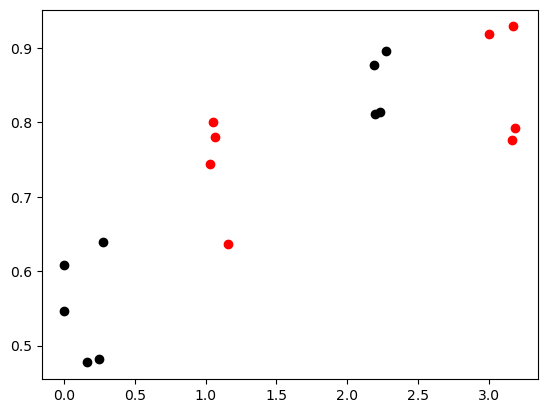

In [45]:
fig, ax = plt.subplots()
rng = np.random.default_rng()
mask = (data['drug']==False)*(data['closed_loop']==True)
_d = data.loc[mask]

print(_d['circvar'])
print(_d['circvar'].mean())
ax.scatter(0+.3*rng.random(size=(_d.shape[0],)), _d['circvar'], color='black')

mask = (data['drug']==True)*(data['closed_loop']==True)
_d = data.loc[mask]

print(_d['circvar'])
print(_d['circvar'].mean())
ax.scatter(1+.3*rng.random(size=(_d.shape[0],)), _d['circvar'], color='red')


mask = (data['drug']==False)*(data['closed_loop']==False)
_d = data.loc[mask]

print(_d['circvar'])
print(_d['circvar'].mean())
ax.scatter(2+.3*rng.random(size=(_d.shape[0],)), _d['circvar'], color='black')

mask = (data['drug']==True)*(data['closed_loop']==False)
_d = data.loc[mask]

print(_d['circvar'])
print(_d['circvar'].mean())
ax.scatter(3+.3*rng.random(size=(_d.shape[0],)), _d['circvar'], color='red')